In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print(" Chargement des données...")

train = pd.read_csv('D:\\Datasets\\ML\\Spam Detection\\train.csv')
test = pd.read_csv('D:\\Datasets\\ML\\Spam Detection\\test.csv')

print(f" Données chargées!")
print(f"  Train: {train.shape}")
print(f"  Test: {test.shape}")

# Vérifier les colonnes
print(f"\n Colonnes train: {list(train.columns[:5])}...{list(train.columns[-2:])}")
print(f" Colonnes test: {list(test.columns[:5])}...{list(test.columns[-1:])}")

print(f"\n Distribution target:")
print(train['target'].value_counts(normalize=True))

train.head()

 Chargement des données...
 Données chargées!
  Train: (600000, 102)
  Test: (540000, 101)

 Colonnes train: ['id', 'f0', 'f1', 'f2', 'f3']...['f99', 'target']
 Colonnes test: ['id', 'f0', 'f1', 'f2', 'f3']...['f99']

 Distribution target:
target
1    0.50601
0    0.49399
Name: proportion, dtype: float64


,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,...,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0
3,3,-0.014077,0.24600,779.9670,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,...,3.47439,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.96860,0.040017,0.044873,0
4,4,-0.003259,3.71542,156.1280,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,...,1.91059,-0.042943,0.105616,0.125072,0.037509,1.043790,1.07481,-0.012819,0.072798,1


In [2]:

# CELLULE 4: Préparation des données
from sklearn.model_selection import train_test_split

# Features: f0 à f99
feature_names = [f'f{i}' for i in range(100)]

# Vérifier que toutes les features existent
missing = [f for f in feature_names if f not in train.columns]
if missing:
    print(f" Features manquantes: {missing}")
else:
    print(f" Toutes les 100 features présentes!")

X = train[feature_names]
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Split:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {test[feature_names].shape}")


 Toutes les 100 features présentes!

 Split:
  X_train: (480000, 100)
  X_val: (120000, 100)
  X_test: (540000, 100)


In [ ]:

# CELLULE 5: Baseline rapide
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import time

print(" Entraînement baseline LightGBM...")
start = time.time()

baseline_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=15,
    learning_rate=0.1,
    num_leaves=100,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

baseline_model.fit(X_train, y_train)
y_val_pred = baseline_model.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, y_val_pred)

print(f" Baseline: {baseline_auc:.4f} (en {time.time()-start:.1f}s)")


🚀 Entraînement baseline LightGBM...
✅ Baseline: 0.7414 (en 32.4s)


In [ ]:

# CELLULE 6: Optimisation avec Optuna
import optuna
from optuna.samplers import TPESampler

print(" OPTUNA - Optimisation Bayésienne")
print("="*60)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)

# Créer l'étude
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

print(f" Lancement de 50 essais...")
start = time.time()

study.optimize(objective, n_trials=50, show_progress_bar=True)

duration = time.time() - start

print(f"\n Optuna terminé en {duration/60:.1f} min")
print(f" MEILLEUR SCORE: {study.best_value:.4f}")
print(f" Amélioration: +{(study.best_value - baseline_auc)*100:.2f}%")

print(f"\n Meilleurs hyperparamètres:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")



[I 2026-01-04 08:03:51,353] A new study created in memory with name: no-name-47a180ec-a4b8-4d4d-bf1f-f4a4e6f6194d


🔥 OPTUNA - Optimisation Bayésienne
🎯 Lancement de 50 essais...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-04 08:04:15,098] Trial 0 finished with value: 0.7415208847106192 and parameters: {'n_estimators': 250, 'max_depth': 24, 'learning_rate': 0.1205712628744377, 'num_leaves': 128, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.7415208847106192.
[I 2026-01-04 08:04:26,981] Trial 1 finished with value: 0.7390323925938884 and parameters: {'n_estimators': 383, 'max_depth': 5, 'learning_rate': 0.2708160864249968, 'num_leaves': 170, 'min_child_samples': 29, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.7415208847106192.
[I 2026-01-04 08:04:56,105] Trial 2 finished with value: 0.7448063591340386 and parameters: {'n_estimators': 273, 'max_depth': 11, 'learning_rate': 0.08012737503998542, 'num_leaves': 45, 'min_ch

In [5]:

# CELLULE 7: Entraînement du modèle final
print("\n🏆 MODÈLE FINAL")
print("="*60)

best_params = study.best_params.copy()
best_params.update({'random_state': 42, 'n_jobs': -1, 'verbose': -1})

# Entraîner sur toutes les données
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_full, y_full)

y_val_pred_final = final_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, y_val_pred_final)

print(f"✅ AUC-ROC final: {final_auc:.4f}")



🏆 MODÈLE FINAL
✅ AUC-ROC final: 0.7986


In [6]:

# CELLULE 8: Prédictions sur le test
print("\n🔮 PRÉDICTIONS FINALES")
print("="*60)

X_test = test[feature_names]
predictions = final_model.predict_proba(X_test)[:, 1]

print(f"✅ {len(predictions)} prédictions générées")
print(f"\nStatistiques:")
print(f"  Min:     {predictions.min():.4f}")
print(f"  Max:     {predictions.max():.4f}")
print(f"  Moyenne: {predictions.mean():.4f}")
print(f"  Médiane: {np.median(predictions):.4f}")




🔮 PRÉDICTIONS FINALES
✅ 540000 prédictions générées

Statistiques:
  Min:     0.0252
  Max:     0.9646
  Moyenne: 0.4910
  Médiane: 0.4894


In [7]:

# CELLULE 9: Création du fichier de soumission
submission = pd.DataFrame({
    'id': test['id'],
    'target': predictions
})

submission.to_csv('submission.csv', index=False)

print("\n✅ Fichier créé: submission.csv")
print(f"\n👀 Aperçu:")
print(submission.head(10))

# Validations
print(f"\n🔍 Vérifications:")
print(f"  ✅ Lignes: {len(submission)}")
print(f"  ✅ IDs uniques: {submission['id'].nunique()}")
print(f"  ✅ Pas de NaN: {submission.isnull().sum().sum() == 0}")
print(f"  ✅ Proba [0,1]: {(submission['target'] >= 0).all() and (submission['target'] <= 1).all()}")




✅ Fichier créé: submission.csv

👀 Aperçu:
       id    target
0  600000  0.625380
1  600001  0.585053
2  600002  0.831875
3  600003  0.491382
4  600004  0.461170
5  600005  0.299599
6  600006  0.481267
7  600007  0.524369
8  600008  0.528834
9  600009  0.217105

🔍 Vérifications:
  ✅ Lignes: 540000
  ✅ IDs uniques: 540000
  ✅ Pas de NaN: True
  ✅ Proba [0,1]: True


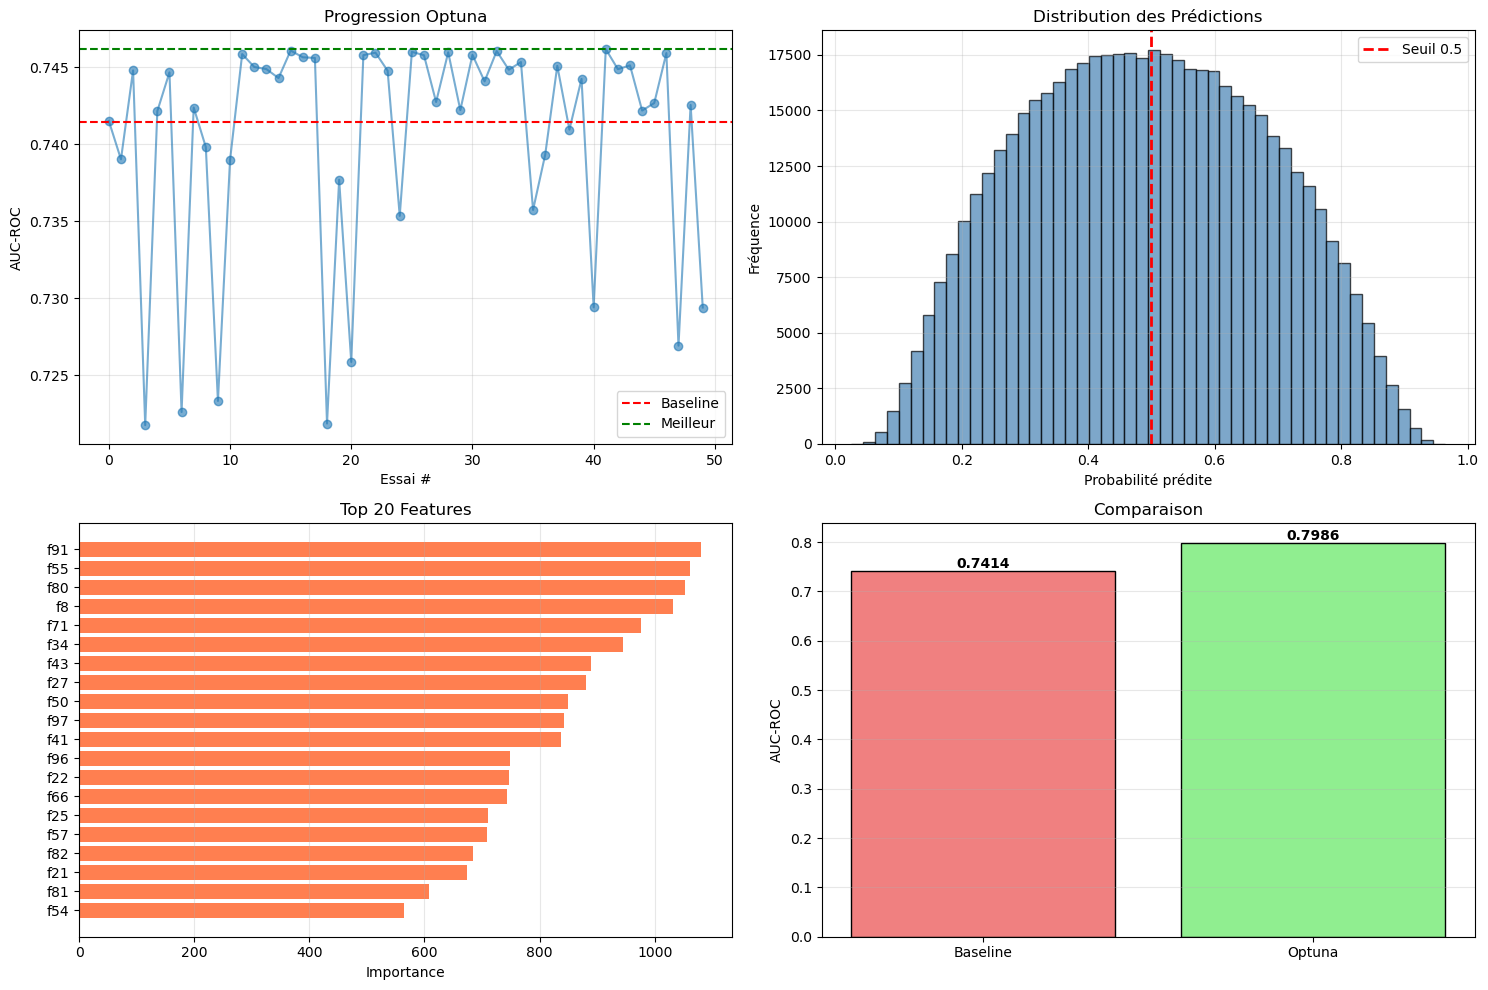

✅ Graphique sauvegardé: results.png


In [8]:

# CELLULE 10: Visualisations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Progression Optuna
trials_df = study.trials_dataframe()
axes[0, 0].plot(trials_df['number'], trials_df['value'], marker='o', alpha=0.6)
axes[0, 0].axhline(baseline_auc, color='red', linestyle='--', label='Baseline')
axes[0, 0].axhline(study.best_value, color='green', linestyle='--', label='Meilleur')
axes[0, 0].set_xlabel('Essai #')
axes[0, 0].set_ylabel('AUC-ROC')
axes[0, 0].set_title('Progression Optuna')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribution prédictions
axes[0, 1].hist(predictions, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Seuil 0.5')
axes[0, 1].set_xlabel('Probabilité prédite')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution des Prédictions')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'], color='coral')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 20 Features')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. Comparaison
comparison = pd.DataFrame({
    'Modèle': ['Baseline', 'Optuna'],
    'AUC-ROC': [baseline_auc, final_auc]
})

bars = axes[1, 1].bar(comparison['Modèle'], comparison['AUC-ROC'], 
                      color=['lightcoral', 'lightgreen'], edgecolor='black')
axes[1, 1].set_ylabel('AUC-ROC')
axes[1, 1].set_title('Comparaison')

for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé: results.png")

